In [ ]:
import pretty_midi
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import random
import sys
import skimage.io as io

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        logits = logits.transpose(0, 1).contiguous()
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [ ]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()

In [ ]:
rnn.load_state_dict(torch.load('models/music_rnn_nottingham_512.pth'))

In [ ]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):
    if starting_sequence is None:
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None
    for i in range(sample_length):
        output, hidden = rnn(current_sequence_input, [1], hidden)
        probabilities = nn.functional.softmax(output.div(temperature), dim=1)
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
        current_sequence_input = current_sequence_input.float()
        final_output_sequence.append(current_sequence_input.data.squeeze(1))
    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

(88, 101)


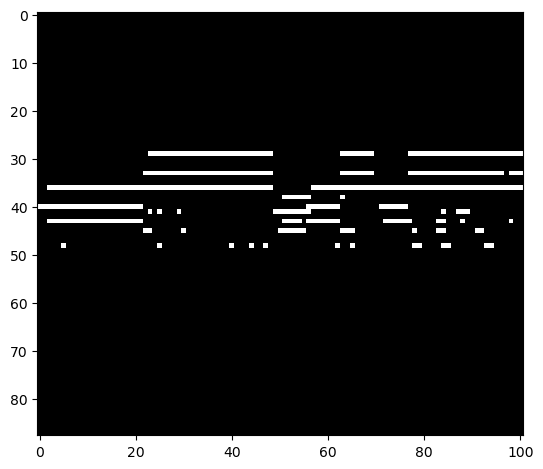

In [14]:
%matplotlib inline

sample = sample_from_piano_rnn(sample_length=100, temperature=0.7).transpose()
print(sample.shape)
io.imshow(sample)

In [17]:
# https://notebook.community/craffel/pretty-midi/Tutorial
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    """Converts numerical matrix to a piano roll midi class using PrettyMidi"""
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI(initial_tempo=80)
    instrument = pretty_midi.Instrument(program=program)
    drum = pretty_midi.Instrument(program=0, is_drum=True)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    # have an array of all possible notes (0 - 87)
    # have an array of velocities that correspond to those notes (all zero to start off with)
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
#         if time % 10 == 0:
#             # add drum note?
#             note = pretty_midi.Note(
#                 velocity=127,
#                 pitch=35,
#                 start=time,
#                 end=time+5)
#             drum.notes.append(note)
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            # add a note if velocity = 0, or the instrument stopped
            pm_note = pretty_midi.Note(
                velocity=127,
                # padded the note with +40 because the piano roll was only 88 instead of 127
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
            
    pm.instruments.append(instrument)
    return pm

In [ ]:
midi = piano_roll_to_pretty_midi(sample, fs=1, program=2)
midi.write('midi3.midi')

In [ ]:
import IPython.display

# midi = pretty_midi.PrettyMIDI('sample.midi')
audio = midi.synthesize()

# Get an .sf2 piano sounds library, for example here https://sites.google.com/site/soundfonts4u/
# Or replace the next line with:
# audio = midi.fluidsynth(fs=12000, sf2_path='../../piano.sf2')

# UNCOMMENT THIS LINE TO PLAY THE MIDI. HOWEVER, you might get file save errors on CSUA cuz it's so much data lol
IPython.display.Audio(audio, rate=12000)

In [11]:
with open('test.wav', 'wb') as f:
    f.write(audio.data)

In [2]:
# Adding rain sounds
# https://github.com/jiaaro/pydub#installation
from pydub import AudioSegment

sound1 = AudioSegment.from_file("test.wav")
sound2 = AudioSegment.from_file("rain.wav")

combined = sound1.overlay(sound2)

combined.export("final_test.wav", format='wav')

<_io.BufferedRandom name='final_test.wav'>

In [ ]:
IPython.display.Audio("final_test.wav")